## Univariate Time Series Models from the ARIMA Family Waling Forward
This notebook contains code for setting up and finetune Arima and Sarima models and make forecasts with those models. We do that both for monthly and weekly data, since the changes in the water level variable are often too insignificant for hourly or daily data.

Structure:
1. preparation of necessary packages and functions
2. Analysis of Monthly Data
3. Models for Montly Data
4. ARIMA Model Monthly
5. SARIMA Model Monthly
6. Analysis of Weekly Data  
7. ARIMA Weekly
8. SARIMA Weekly


Sources:

- Korstanje, J. 2022.  How to Select a Model For Your Time Series Prediction Task. Retrieved from: https://neptune.ai/blog/select-model-for-time-series-prediction-task 

- Graves, A. 2020. Time Series Forecasting with a SARIMA Model. Retrieved from: https://towardsdatascience.com/time-series-forecasting-with-a-sarima-model-db051b7ae459
- https://github.com/mfriebel/waterlevel_prediction

# 1. Preparation of necessary Packages and Functions

In [1]:
# load necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.model_selection import train_test_split
from datetime import datetime, timedelta


In [2]:
## import and prepare montly data

monthly_data = pd.read_csv("../Data/clean_data/monthly_data.csv")
# convert DateTime column into datetime format
monthly_data["datetime"] = pd.to_datetime(monthly_data['datetime'])
# set DateTime as index
monthly_data.set_index("datetime", inplace=True)
# subset the water_level variable since we are using univariate models
water_monthly = monthly_data[["water_level"]]

## import and prepare weekly data

weekly_data = pd.read_csv("../Data/clean_data/weekly_data.csv")
# convert DateTime column into datetime format
weekly_data["datetime"] = pd.to_datetime(weekly_data['datetime'])
# set DateTime as index
weekly_data.set_index("datetime", inplace=True)
# subset the water_level variable since we are using univariate models
water_weekly = weekly_data[["water_level"]]

In [6]:
# function for calculating different performance measures, namely the MAE, MSE, MAPE and the R-squared

from sklearn.metrics import mean_absolute_error as mae
import numpy as np
from sklearn.metrics import r2_score

def mean_errors(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    MAE = mae(actual, pred)
    MSE = np.square(np.subtract(actual,pred)).mean()
    MAPE = np.mean(np.abs((actual - pred) / actual)) * 100
    R2_score = r2_score(actual, pred)
    return print("MAE: {} \nMSE: {} \nMAPE: {} \nR2: {}".format(MAE, MSE, MAPE, R2_score))

In [114]:
# function for Arima model with walking forward validation

def walk_forward_validation_ARIMA(train, test, order):     # takes train and test data as well as the order parameters p,d,q as arguments
    window=1 # setting the prediction steps to one month
    forecast_series = pd.DataFrame(index=test.index, columns=[x for x in range(window)]) #create an empty dataframe for storing the forecasts in with length of validation dataset
        
    # loop over the timespan of the validation data, predicting the next observation, retraining the model, store the forecasts in the dedicated dataframe and add the actual value
    # of the prediction to the trainings data to constantly train the model after each step
    training_data = train.copy()
    for i in test.index:
        model = ARIMA(training_data, order=order).fit()
        forecast_series.loc[i] = model.forecast(window)[0]
        training_data.loc[i] = test.loc[i]
        columns = [f'yt+{x}' for x in forecast_series.columns]
    forecast_series.columns = columns
    # return the predictions and the fittet model
    return forecast_series.astype(float), model

In [148]:
# function for Sarima model with walking forward validation

def walk_forward_validation_SARIMA(train, test, order, seasonalorder):       # takes train and test data as well as the order/seasonal order parameters p,d,q/P,D,Q,s as arguments
    window=1  # setting prediction steps to one week 
    forecast_series = pd.DataFrame(index=test.index, columns=[x for x in range(window)])  #create an empty dataframe for storing the forecasts in with length of validation dataset 
    training_data = train.copy()   # training data from the input
    
    # loop over the timespan of the validation data, predicting the next observation, retraining the model, store the forecasts in the dedicated dataframe and add the actual value
    # of the prediction to the trainings data to constantly train the model after each step
    for i in test.index:          
        model = ARIMA(training_data, order=order, seasonal_order=seasonalorder).fit()
        forecast_series.loc[i] = model.forecast(window)[0]
        training_data.loc[i] = test.loc[i]
        columns = [f'yt+{x}' for x in forecast_series.columns]
    forecast_series.columns = columns
    # return the predictions and the fittet model
    return forecast_series.astype(float), model

# 2. Analysis of Monthly Data

Decompose montly data into trend, serial and white noise components

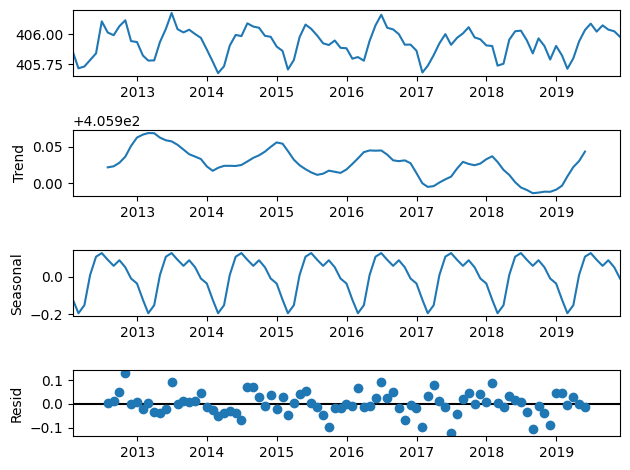

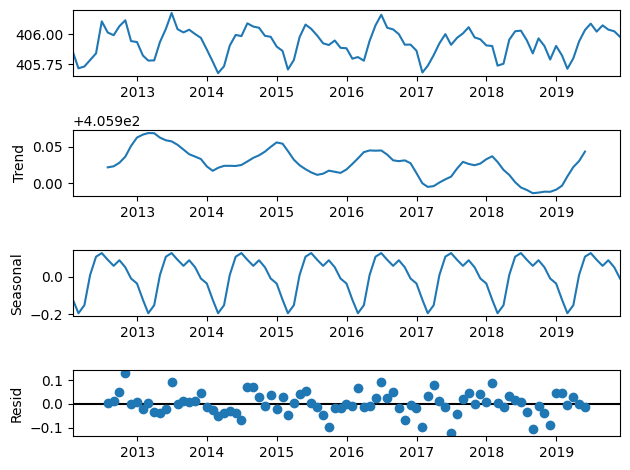

In [6]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_monthly).plot()

Checking for stationarity using the Partial Autocorrelation Plot

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


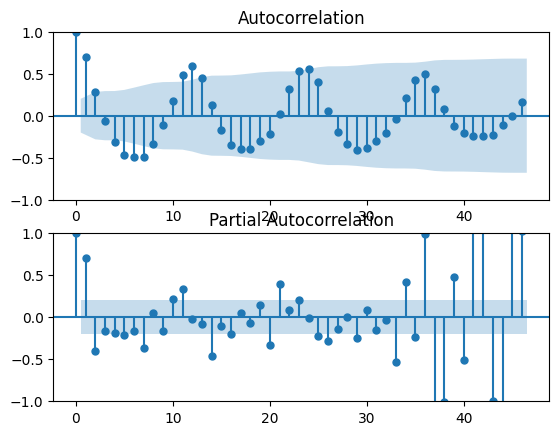

In [7]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_monthly, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_monthly, lags=46, ax=ax[1])
plt.show()

# the first two lags of the partial autocorrelation are still significant which suggests that the time series is non-stationary 

Checking for stationarity using the ADF test

In [9]:
# check for stationarity with the ADF test using the adfuller function
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_monthly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# the p value is above 0.05, so the null hypthesis gets rejected and the water level time series is non-stationary 

ADF test statistic: -2.4233565623253295
ADF p-values: 0.13525240781777587
ADF number of lags used: 10
ADF number of observations: 84
ADF critical values: {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
ADF best information criterion: -210.3294454437903


Differencing

<AxesSubplot: xlabel='datetime'>

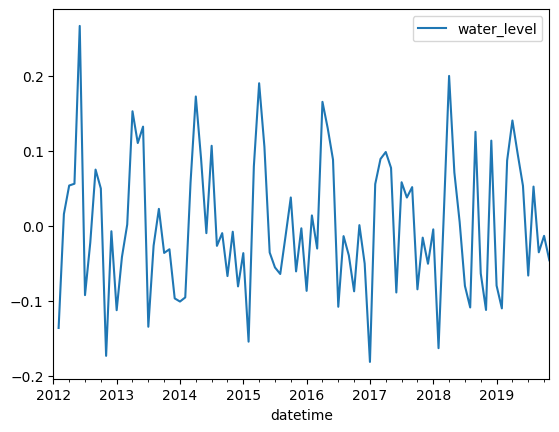

In [10]:
# differencing water level data to make it stationary 
prev_monthly_value = water_monthly.shift()
differenced_monthly = water_monthly - prev_monthly_value
differenced_monthly.plot()

check for stationarity again

In [11]:
# ADF test on differenced data, the p value is now below 0.05 and suggests that the time series is now stationary after differencing once
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(differenced_monthly.dropna())
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.117132704753469
ADF p-values: 0.025310999379347113
ADF number of lags used: 12
ADF number of observations: 81
ADF critical values: {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
ADF best information criterion: -203.27107481438185


# 3. Arima Model Monthly


Train and Test split

In [105]:
# split data into training data used for training and validating the model (2012-2018) and into test data (2019) used for a final test of the models performance
train, test = train_test_split(water_monthly, train_size=84)
# split the trainings data into training (2012-2016) and validation data (2016-2018)
train_val, test_val = train_test_split(train, train_size=60)

Instantiate, train and validate model with walking forward 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

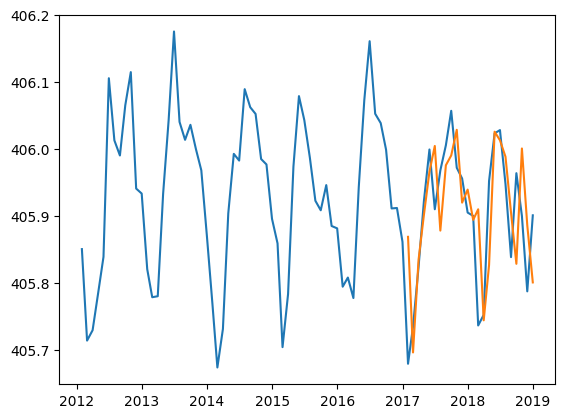

MAE: 0.06547308818493036 
MSE: 0.006965666859694388 
MAPE: 0.016131452151471003 
R2: 0.3202370107626513
None


In [139]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2
# since the monthly data was non-stationary we chose d=1 to difference the data once
# the first two lags of the PACF curve had significant autocorrelation (one positive and one negative)  which is why we set p=2 and q=1

wf_arima_preds, arima_model_m= walk_forward_validation_ARIMA(train_val, test_val, (2,1,1))

# plotting actual and predicted water level
plt.plot(train.index, train)
plt.plot(test_val.index, wf_arima_preds)
plt.show()

# print performance indicators
print(mean_errors(test_val, wf_arima_preds))

Final testing monthly arima model

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

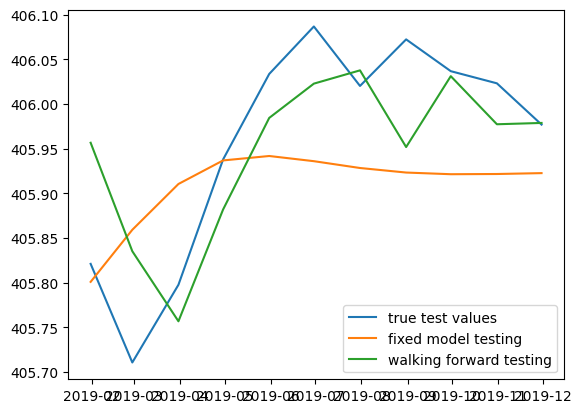

fixed parameters: 

MAE: 0.0942627714257624 
MSE: 0.01798099479991459 
MAPE: 0.02946158859084015 
R2: 0.2080915879667472
None 

walking forward: 

MAE: 0.06010115649675382 
MSE: 0.0056472127226533326 
MAPE: 0.014806252345016813 
R2: 0.6016136922697857
None


In [146]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each month). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast using walking forward with updating data  
forecast_arima_monthly_wf, a = walk_forward_validation_ARIMA(train, test, (2,1,1))

# forecast using the fixed model without walking forward 
forecast_arima_monthly = arima_model_m.forecast(len(test))

# plotting actual and forcasted water level for 2019
plt.plot(test.index, test, label="true test values")
plt.plot(test.index, forecast_arima_monthly, label="fixed model testing")
plt.plot(test.index, forecast_arima_monthly_wf, label="walking forward testing")
plt.legend()
plt.show()

# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test, forecast_arima_monthly),"\n")
print("walking forward: \n")
print(mean_errors(test, forecast_arima_monthly_wf))

# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 


# 4. SARIMA Model Monthly 

Instantiate, Fit, Train and Validate Sarima Model

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978

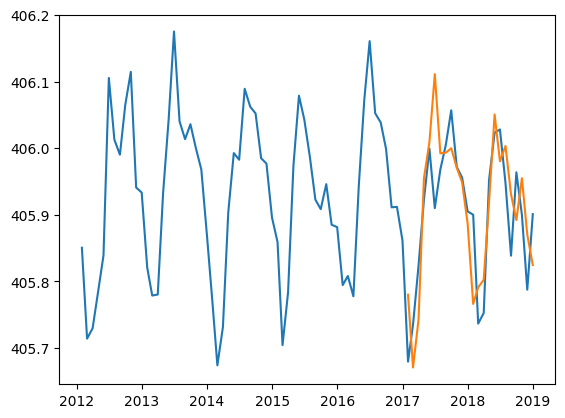

MAE: 0.057861853042867985 
MSE: 0.005272937113366602 
MAPE: 0.014256093993440015 
R2: 0.48542651171234785
None


In [149]:
# instantiate and fit Sarima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2
# here we set similar parameters like in the ARIMA model but add seasonal parameters, s=12 because we have monthly observations

wf_sarima_preds, sarima_model_m= walk_forward_validation_SARIMA(train_val, test_val, (2,1,1),(2,1,1,12))

# plotting actual and predicted water level
plt.plot(train.index, train)
plt.plot(test_val.index, wf_sarima_preds)
plt.show()

# print performance indicators
print(mean_errors(test_val, wf_sarima_preds))

final testing monthly sarima

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

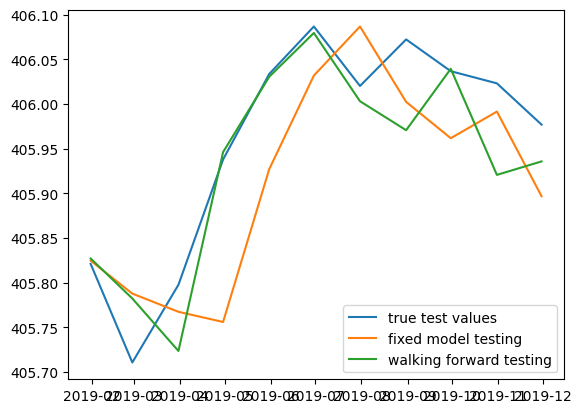

fixed parameters: 

MAE: 0.07067911374799575 
MSE: 0.02797061809315591 
MAPE: 0.03348628529254559 
R2: 0.5082515778604695
None 

walking forward: 

MAE: 0.03956831060933878 
MSE: 0.0030535083690203806 
MAPE: 0.00974740128461596 
R2: 0.7845882589339083
None


In [151]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each month). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with the previously selected model using walking forward with updating data  
forecast_sarima_monthly_wf, b = walk_forward_validation_SARIMA(train, test, (2,1,1),(2,1,1,12))

# forecast using the fixed model without walking forward 
forecast_sarima_monthly = sarima_model_m.forecast(len(test))

# plotting actual and forcasted water level for 2019
plt.plot(test.index, test, label="true test values")
plt.plot(test.index, forecast_sarima_monthly, label="fixed model testing")
plt.plot(test.index, forecast_sarima_monthly_wf, label="walking forward testing")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test, forecast_sarima_monthly),"\n")
print("walking forward: \n")
print(mean_errors(test, forecast_sarima_monthly_wf))

# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 
# In parts this model performs better than the ARIMA model, in some not

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


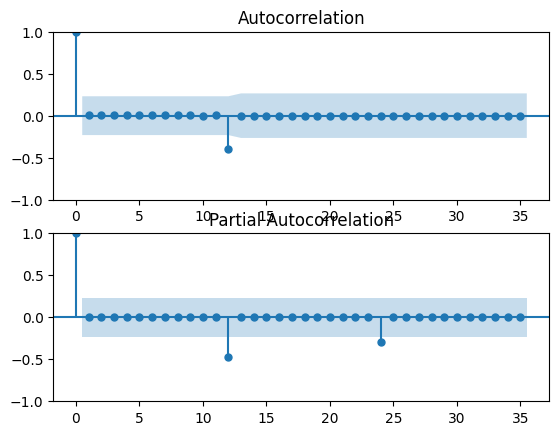

In [40]:
# plot ACF and PACF curve for residuals of SARIMA model

res = model_max.resid

fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=35, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=35, ax=ax[1])
plt.show()

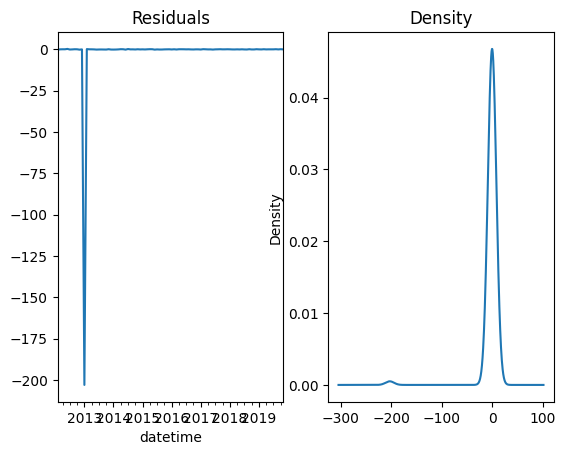

In [140]:
residuals = model_manual_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()


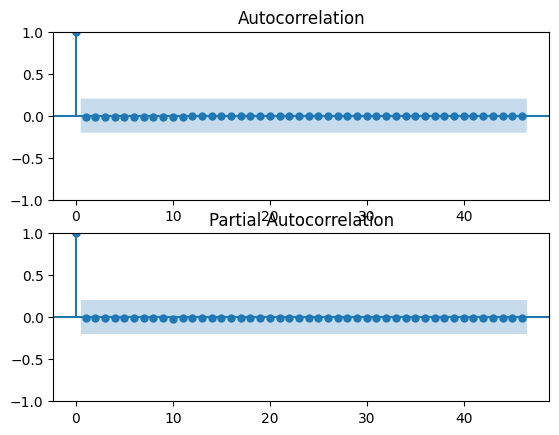

In [143]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(residuals, lags=46, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=46, ax=ax[1])
plt.show()

# Analysis of Weekly Data

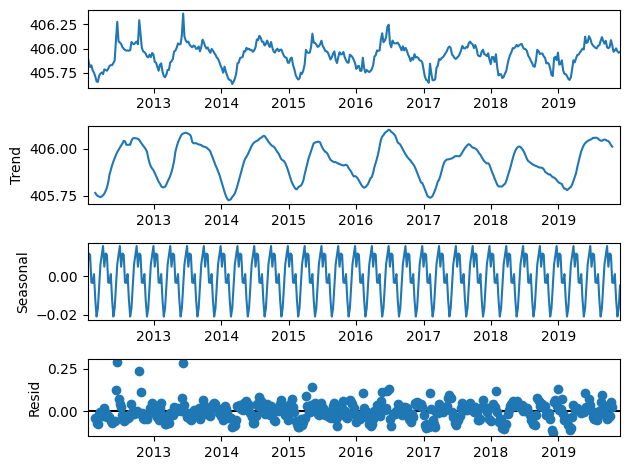

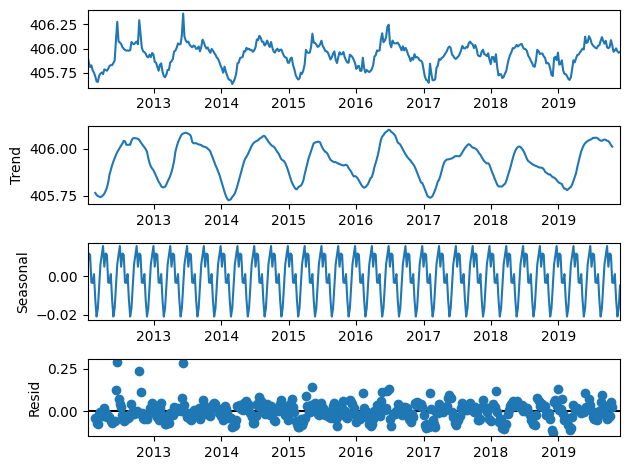

In [152]:
# decompose the monthly data to find out trends and and seasonalites 
seasonal_decompose(water_weekly,  period=13).plot()

# setting period to 13 to find quarterly seasonalities

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


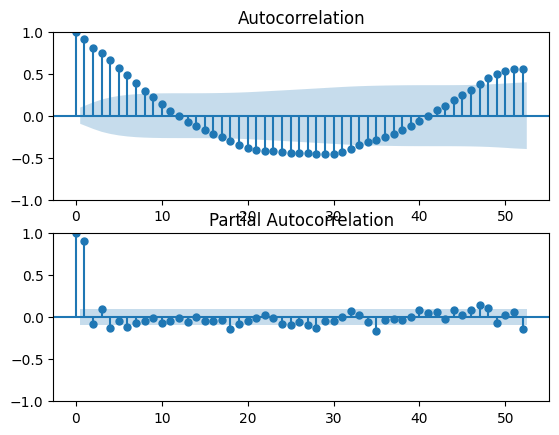

In [153]:
# plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(water_weekly, lags=52, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(water_weekly, lags=52, ax=ax[1])
plt.show()


In [154]:
# check for stationarity with the ADF test
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(water_weekly)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

# the p value is below 0.05 and the the partial autocorrleation plot shows just one significant lag which might suggest that the data is stationary

ADF test statistic: -5.09506601651987
ADF p-values: 1.4342811249084213e-05
ADF number of lags used: 5
ADF number of observations: 407
ADF critical values: {'1%': -3.4465195891135845, '5%': -2.8686676281678634, '10%': -2.5705668101226085}
ADF best information criterion: -1212.8315919588013


Train and Test splits

In [165]:
# split weekly data into a final test set containing data from 2019 and a trainings set that is used for training and validating the models 
train_we, test_we = train_test_split(water_weekly, train_size=365)
# split the weekly training data again into training data (data from 2012 - 2016) and test data used for validation (data for 2017 and 2018)
train_val_we, test_val_we = train_test_split(train_we, train_size=260)

# 7. Arima Model Weekly
instantiate, fit and validate an ARIMA model 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency infor

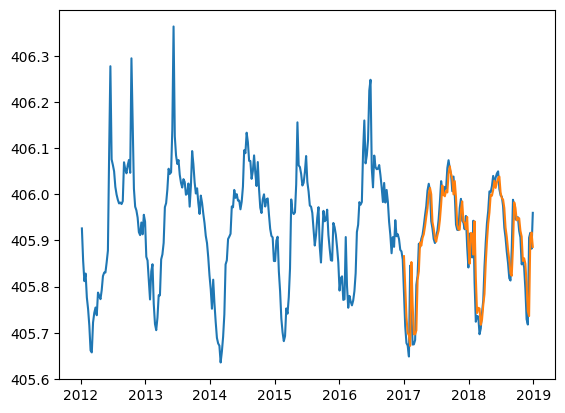

MAE: 0.035377448072465324 
MSE: 0.002347215565735733 
MAPE: 0.008716366344369817 
R2: 0.7962343673695798
None


In [175]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2 
# since the data is stationary and has not significant negative partial autocorrelations we set d=0 and q=0
wf_arima_preds_we, arima_model_w= walk_forward_validation_ARIMA(train_val_we, test_val_we, (1,0,0))

# plotting actual and predicted water level
plt.plot(train_we.index, train_we)
plt.plot(test_val_we.index, wf_arima_preds_we)
plt.show()

# print performance indicators
print(mean_errors(test_val_we, wf_arima_preds_we))

Final Testing with Data from 2019

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency infor

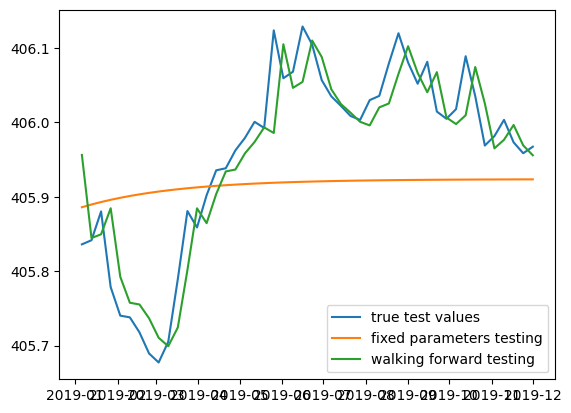

fixed parameters: 

MAE: 0.10823355600071949 
MSE: 0.017192805309343362 
MAPE: 0.028553570152546073 
R2: 0.0013105637171278994
None 

walking forward: 

MAE: 0.035057724803245094 
MSE: 0.0021643468920269355 
MAPE: 0.00863591707808169 
R2: 0.859195282890153
None


In [178]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each week). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with models from above using walking forward with updating data after each step (week)   
forecast_arima_weekly_wf, c = walk_forward_validation_ARIMA(train_we, test_we, (1,0,0))

# forecast using the fixed model without walking forward 
forecast_arima_weekly = arima_model_w.forecast(len(test_we))

# plotting actual and forcasted water level for 2019
plt.plot(test_we.index, test_we, label="true test values")
plt.plot(test_we.index, forecast_arima_weekly, label="fixed parameters testing")
plt.plot(test_we.index, forecast_arima_weekly_wf, label="walking forward testing")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test_we, forecast_arima_weekly),"\n")
print("walking forward: \n")
print(mean_errors(test_we, forecast_arima_weekly_wf))
# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 

# 8. Seasonal ARIMA Model Weekly
instantiate, fit and validate SARIMA model with weekly data 

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency infor

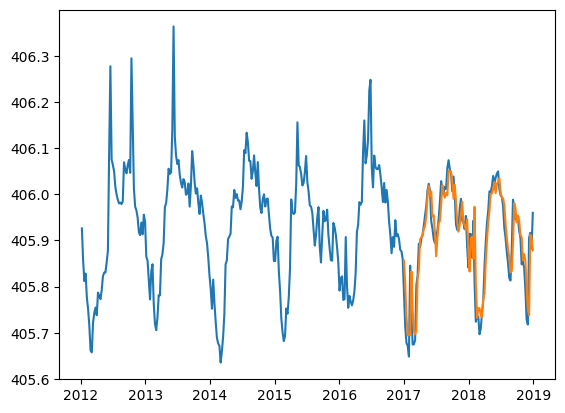

MAE: 0.03516112874132908 
MSE: 0.0023128106159984027 
MAPE: 0.008663068988424347 
R2: 0.7992211174794477
None


In [173]:
# instantiate and fit arima model manually with parameters
# optimize for model with the lowest mean errors and the highest R2 
# we orient ourself on the parameters from the ARIMA model, s=52 because we are dealing with weekly data
wf_sarima_preds_we, sarima_model_w = walk_forward_validation_SARIMA(train_val_we, test_val_we, (1,0,0), (1,0,0,52))

# plotting actual and predicted water level
plt.plot(train_we.index, train_we)
plt.plot(test_val_we.index, wf_sarima_preds_we)
plt.show()

# print performance indicators
print(mean_errors(test_val_we, wf_sarima_preds_we))

Final Testing with Data from 2019

c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\lucal\miniconda3\envs\dsf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency infor

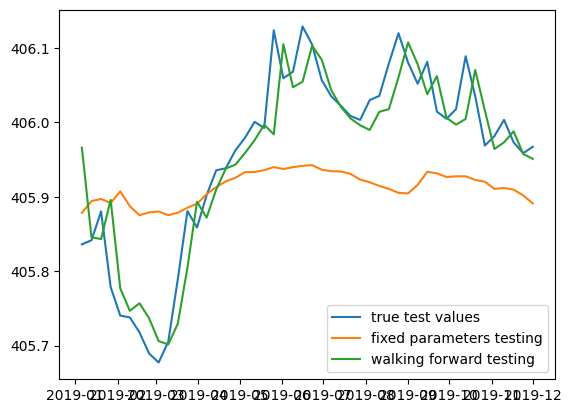

fixed parameters: 

MAE: 0.10193605859704273 
MSE: 0.017734695771570677 
MAPE: 0.02886963328192475 
R2: 0.11594994193128894
None 

walking forward: 

MAE: 0.03485736796358315 
MSE: 0.002244413991532727 
MAPE: 0.00858646004866876 
R2: 0.8539864019398535
None


In [174]:
# we are using the final testset to test the models performance for unseen data from the year 2019. This way we want to simulate how the model would perform in the real world

# we are using two approaches:
# the first one forcasts the water level for 2019 while using the walking forward approach. While we are using the model that we trained before (same parameters), we are updating 
# the data after each prediction step. This approach would simulate a model that evolves with new data and renders thus more robust results 

# on the other hand we are comparing our model´s performance if we would take the model but do not feed new data to the model after each prediction (after each week). We are 
# rather forecasting with the fixed parameters over a longer period (in this case for the year 2019). Since we are not regularly updating our data, this predictions are less
# precise as one can see by comparing the error measures and plots

# forecast with models from above using walking forward with updating data after each step (week)   
forecast_sarima_weekly_wf, d = walk_forward_validation_SARIMA(train_we, test_we, (1,0,0), (1,0,0,52))

# forecast using the fixed model without walking forward 
forecast_sarima_weekly = sarima_model_w.forecast(len(test_we))

# plotting actual and forcasted water level for 2019
plt.plot(test_we.index, test_we, label="true test values")
plt.plot(test_we.index, forecast_sarima_weekly, label="fixed parameters testing")
plt.plot(test_we.index, forecast_sarima_weekly_wf, label="walking forward testing")
plt.legend()
plt.show()


# print performance indicators
print("fixed parameters: \n")
print(mean_errors(test_we, forecast_sarima_weekly),"\n")
print("walking forward: \n")
print(mean_errors(test_we, forecast_sarima_weekly_wf))
# As expected the walking forward model performs better than the fixed model and is more able to predict the true variations in the water level 